In [42]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
import numpy as np
from tqdm import tqdm
import pandas as pd
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim

sys.path.append(str(Path("..").resolve()))
from src import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# [Synthetic Calcium Imaging](https://zenodo.org/records/6254739)
This dataset comes from the training and validation open resources of *DeepCAD-RT*. 

Please download and extract it into `dataset/zenodo/synthetic` using:
```sh
wget https://zenodo.org/api/records/6254739/files-archive
unzip files-archive
rm files-archive
```

In [95]:
x_paths = sorted(
    [_ for _ in DATASETS["synthetic"].dir.glob("*.tif") if "clean" not in _.stem],
    key=lambda _: float(_.stem.split("_")[-2].split("dBSNR")[0]),
)
cprint(*[f"rand:{' - '.join(_.stem.split('_')[1:-1])}" for _ in x_paths], sep="\n")

1Q - -5.52dBSNR
2Q - -2.51dBSNR
4Q - 0.48dBSNR
7Q - 2.88dBSNR
12Q - 5.17dBSNR
20Q - 7.31dBSNR
40Q - 10.14dBSNR
75Q - 12.56dBSNR
150Q - 14.98dBSNR
375Q - 17.56dBSNR


In [ ]:
y_path = DATASETS["synthetic"].dir / "clean_30Hz_490x490x6000.tif"
y = Recording(y_path, max_frames=1).normalized
xs = {f.stem[:-13]: Recording(f, max_frames=1).normalized for f in x_paths}

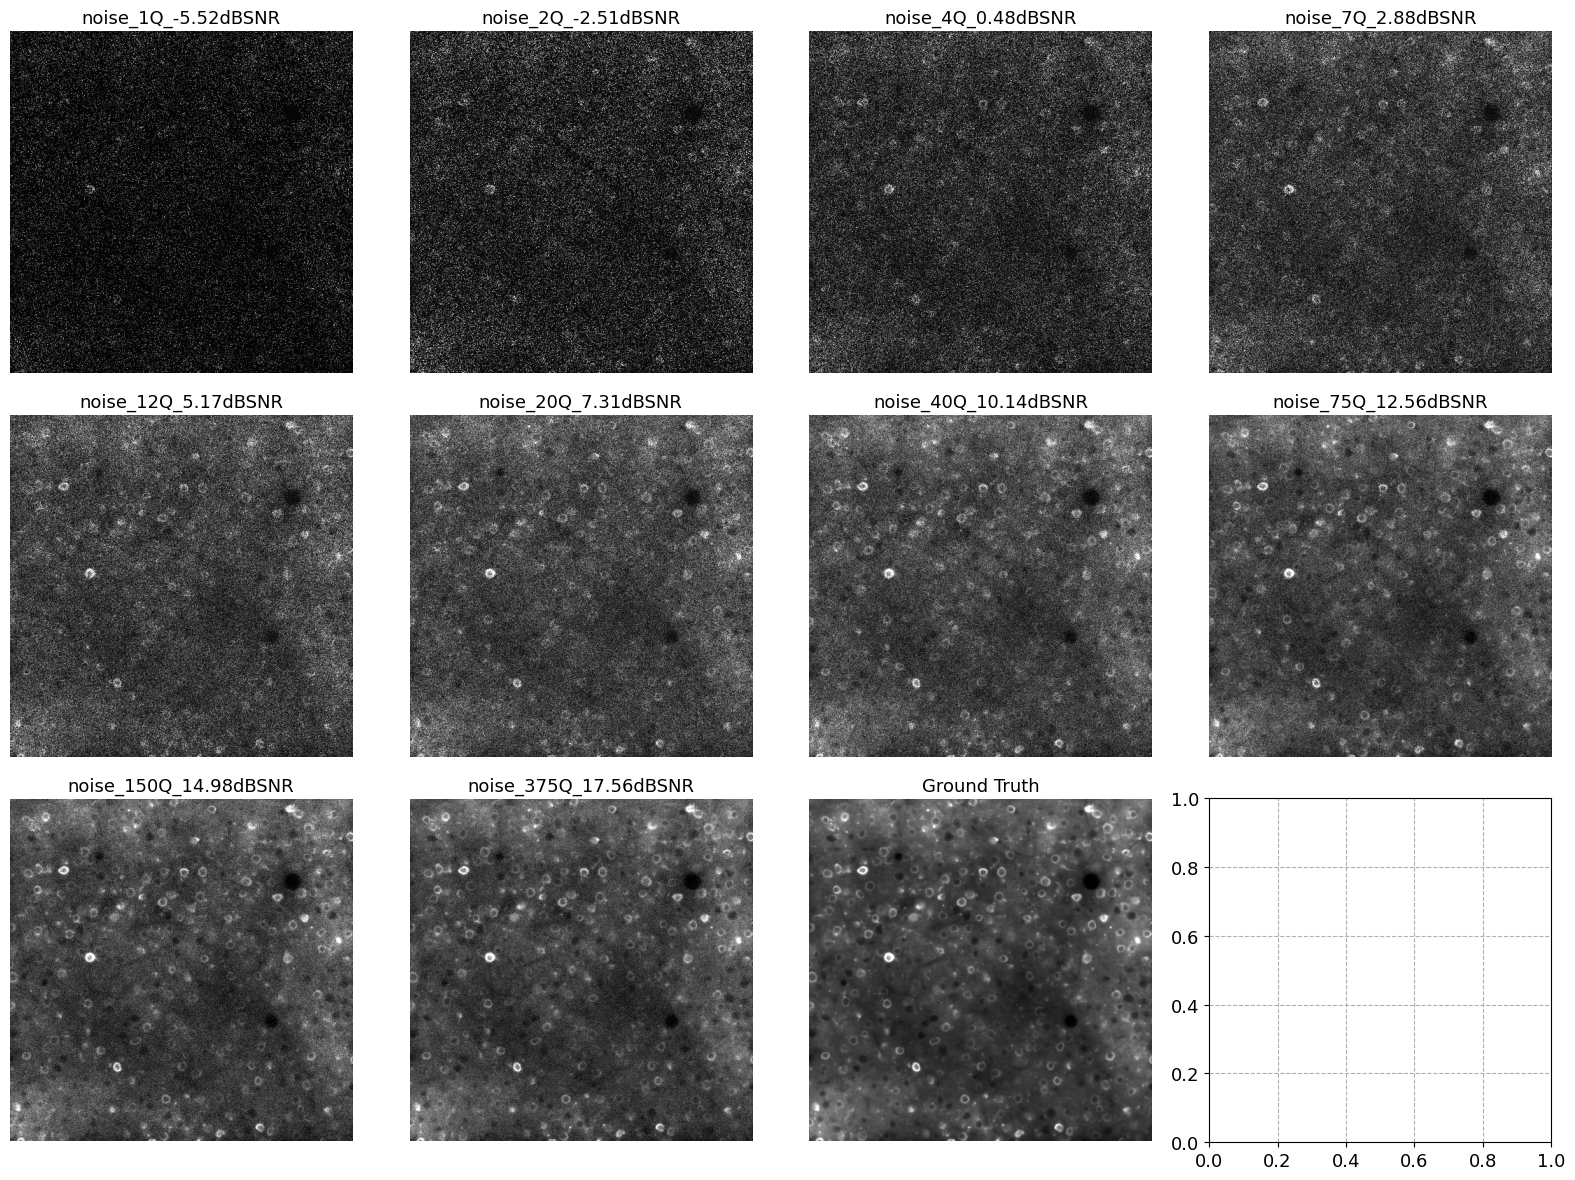

In [109]:
imshow({**xs, "Ground Truth": y}, cols=4, vrange=(0,1))

## PSNR and SSIM
My PSNR calculation is made with data normalized in [0,1] so it won't be negative (if `data_range=1`).

In [64]:
psnrs = {k.split("_")[1].split("_")[0]: psnr(y, x, data_range=1) for k, x in tqdm(xs.items())}
ssims = {k.split("_")[1].split("_")[0]: ssim(y, x, data_range=1) for k, x in tqdm(xs.items())}

100%|██████████| 10/10 [00:00<00:00, 113.84it/s]


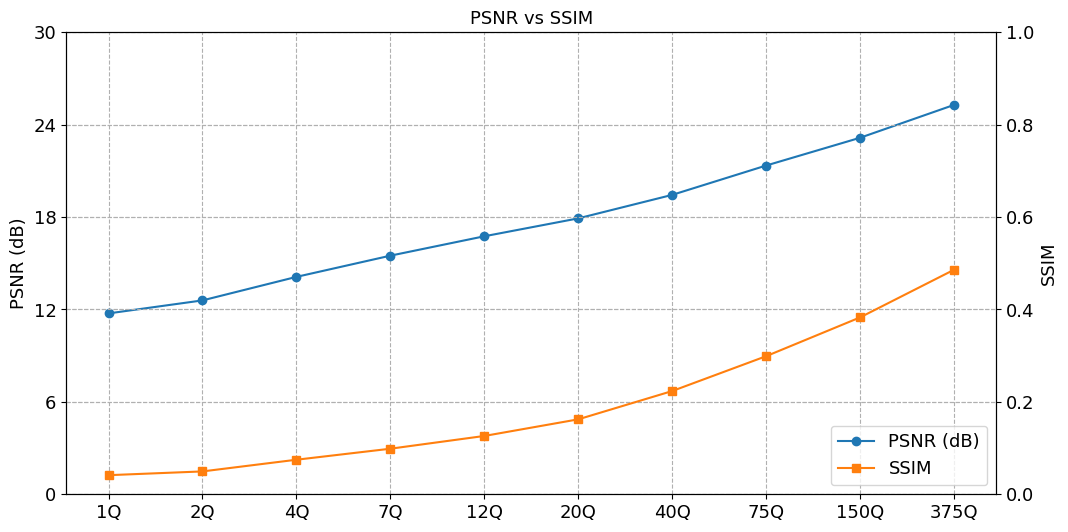

In [99]:
df = pd.DataFrame({"PSNR (dB)": psnrs, "SSIM": ssims})
fig, ax1 = plt.subplots(figsize=(12, 6))
df["PSNR (dB)"].plot(marker="o", ax=ax1, color="tab:blue", label="PSNR (dB)")
ax1.set_ylabel("PSNR (dB)")
ax1.set_ylim(0, 30)
ax1.set_yticks(range(0, 31, 6))
ax1.set_xticks(range(len(df)))

ax2 = ax1.twinx()
df["SSIM"].plot(marker="s", ax=ax2, color="tab:orange", label="SSIM")
ax2.set_ylabel("SSIM")
ax2.set_ylim(0, 1)

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2, loc="lower right")

plt.title("PSNR vs SSIM")
plt.show()